In [30]:
import tensorflow as tf
import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, LayerNormalization, Flatten 
from tensorflow.keras.layers import Add, Concatenate, Lambda, Input, Permute
from tensorflow.keras.regularizers import L2
from tensorflow.keras.constraints import max_norm

from tensorflow.keras import backend as K

from attention_models import attention_block
from attention_models import mha_block
from preprocess_data import *
import time

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#%% Convolutional (CV) block used in the ATCNet model
def Conv_block(input_layer, F1=4, kernLength=64, poolSize=8, D=2, in_chans=22, dropout=0.1):
    """ Conv_block
    
        Notes
        -----
        This block is the same as EEGNet with SeparableConv2D replaced by Conv2D 
        The original code for this model is available at: https://github.com/vlawhern/arl-eegmodels
        See details at https://arxiv.org/abs/1611.08024
    """
    F2= F1*D
    block1 = Conv2D(F1, (kernLength, 1), padding = 'same',data_format='channels_last',use_bias = False)(input_layer)
    block1 = BatchNormalization(axis = -1)(block1)
    block2 = DepthwiseConv2D((1, in_chans), use_bias = False, 
                                    depth_multiplier = D,
                                    data_format='channels_last',
                                    depthwise_constraint = max_norm(1.))(block1)
    block2 = BatchNormalization(axis = -1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8,1),data_format='channels_last')(block2)
    block2 = Dropout(dropout)(block2)
    block3 = Conv2D(F2, (16, 1),
                            data_format='channels_last',
                            use_bias = False, padding = 'same')(block2)
    block3 = BatchNormalization(axis = -1)(block3)
    block3 = Activation('elu')(block3)
    
    block3 = AveragePooling2D((poolSize,1),data_format='channels_last')(block3)
    block3 = Dropout(dropout)(block3)
    return block3

def Conv_block_(input_layer, F1=4, kernLength=64, poolSize=8, D=2, in_chans=22, 
                weightDecay = 0.009, maxNorm = 0.6, dropout=0.25):
    """ Conv_block
    
        Notes
        -----
        using  different regularization methods.
    """
    
    F2= F1*D
    block1 = Conv2D(F1, (kernLength, 1), padding = 'same', data_format='channels_last', 
                    kernel_regularizer=L2(weightDecay),
                    
                    # In a Conv2D layer with data_format="channels_last", the weight tensor has shape 
                    # (rows, cols, input_depth, output_depth), set axis to [0, 1, 2] to constrain 
                    # the weights of each filter tensor of size (rows, cols, input_depth).
                    kernel_constraint = max_norm(maxNorm, axis=[0,1,2]),
                    use_bias = False)(input_layer)
    block1 = BatchNormalization(axis = -1)(block1)  # bn_axis = -1 if data_format() == 'channels_last' else 1
    
    block2 = DepthwiseConv2D((1, in_chans),  
                             depth_multiplier = D,
                             data_format='channels_last',
                             depthwise_regularizer=L2(weightDecay),
                             depthwise_constraint  = max_norm(maxNorm, axis=[0,1,2]),
                             use_bias = False)(block1)
    block2 = BatchNormalization(axis = -1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8,1),data_format='channels_last')(block2)
    block2 = Dropout(dropout)(block2)
    
    block3 = Conv2D(F2, (16, 1),
                            data_format='channels_last',
                            kernel_regularizer=L2(weightDecay),
                            kernel_constraint = max_norm(maxNorm, axis=[0,1,2]),
                            use_bias = False, padding = 'same')(block2)
    block3 = BatchNormalization(axis = -1)(block3)
    block3 = Activation('elu')(block3)
    
    block3 = AveragePooling2D((poolSize,1),data_format='channels_last')(block3)
    block3 = Dropout(dropout)(block3)
    return block3

In [3]:
#%% Temporal convolutional (TC) block used in the ATCNet model
def TCN_block(input_layer,input_dimension,depth,kernel_size,filters,dropout,activation='relu'):
    """ TCN_block from Bai et al 2018
        Temporal Convolutional Network (TCN)
        
        Notes
        -----
        THe original code available at https://github.com/locuslab/TCN/blob/master/TCN/tcn.py
        This implementation has a slight modification from the original code
        and it is taken from the code by Ingolfsson et al at https://github.com/iis-eth-zurich/eeg-tcnet
        See details at https://arxiv.org/abs/2006.00622

        References
        ----------
        .. Bai, S., Kolter, J. Z., & Koltun, V. (2018).
           An empirical evaluation of generic convolutional and recurrent networks
           for sequence modeling.
           arXiv preprint arXiv:1803.01271.
    """    
    
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(input_layer)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    if(input_dimension != filters):
        conv = Conv1D(filters,kernel_size=1,padding='same')(input_layer)
        added = Add()([block,conv])
    else:
        added = Add()([block,input_layer])
    out = Activation(activation)(added)
    
    for i in range(depth-1):
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(out)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        added = Add()([block, out])
        out = Activation(activation)(added)
        
    return out

def TCN_block_(input_layer,input_dimension,depth,kernel_size,filters, dropout,
               weightDecay = 0.009, maxNorm = 0.6, activation='relu'):
    """ TCN_block from Bai et al 2018
        Temporal Convolutional Network (TCN)
        
        Notes
        -----
        using different regularization methods
    """    
    
    block = Conv1D(filters, kernel_size=kernel_size, dilation_rate=1, activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),
                    
                    padding = 'causal',kernel_initializer='he_uniform')(input_layer)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),

                    padding = 'causal',kernel_initializer='he_uniform')(block)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    if(input_dimension != filters):
        conv = Conv1D(filters,kernel_size=1,
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),
                      
                    padding='same')(input_layer)
        added = Add()([block,conv])
    else:
        added = Add()([block,input_layer])
    out = Activation(activation)(added)
    
    for i in range(depth-1):
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),
                    
                   padding = 'causal',kernel_initializer='he_uniform')(out)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                    kernel_regularizer=L2(weightDecay),
                    kernel_constraint = max_norm(maxNorm, axis=[0,1]),

                    padding = 'causal',kernel_initializer='he_uniform')(block)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        added = Add()([block, out])
        out = Activation(activation)(added)
        
    return out

In [4]:
#%% The proposed ATCNet model, https://doi.org/10.1109/TII.2022.3197419
def ATCNet_(n_classes, in_chans = 22, in_samples = 1125, n_windows = 5, attention = 'mha', 
           eegn_F1 = 16, eegn_D = 2, eegn_kernelSize = 64, eegn_poolSize = 7, eegn_dropout=0.3, 
           tcn_depth = 2, tcn_kernelSize = 4, tcn_filters = 32, tcn_dropout = 0.3, 
           tcn_activation = 'elu', fuse = 'average'):
    
    """ ATCNet model from Altaheri et al 2023.
        See details at https://ieeexplore.ieee.org/abstract/document/9852687
    
        Notes
        -----
        The initial values in this model are based on the values identified by
        the authors
        
        References
        ----------
        .. H. Altaheri, G. Muhammad, and M. Alsulaiman. "Physics-informed 
           attention temporal convolutional network for EEG-based motor imagery 
           classification." IEEE Transactions on Industrial Informatics, 
           vol. 19, no. 2, pp. 2249-2258, (2023) 
           https://doi.org/10.1109/TII.2022.3197419
    """
    input_1 = Input(shape = (1,in_chans, in_samples))   #     TensorShape([None, 1, 22, 1125])
    input_2 = Permute((3,2,1))(input_1) 

    dense_weightDecay = 0.5  
    conv_weightDecay = 0.009
    conv_maxNorm = 0.6
    from_logits = False

    numFilters = eegn_F1
    F2 = numFilters*eegn_D

    block1 = Conv_block_(input_layer = input_2, F1 = eegn_F1, D = eegn_D, 
                        kernLength = eegn_kernelSize, poolSize = eegn_poolSize,
                        weightDecay = conv_weightDecay, maxNorm = conv_maxNorm,
                        in_chans = in_chans, dropout = eegn_dropout)
    block1 = Lambda(lambda x: x[:,:,-1,:])(block1)
       
    # Sliding window 
    sw_concat = []   # to store concatenated or averaged sliding window outputs
    for i in range(n_windows):
        st = i
        end = block1.shape[1]-n_windows+i+1
        block2 = block1[:, st:end, :]
        
        # Attention_model
        if attention is not None:
            if (attention == 'se' or attention == 'cbam'):
                block2 = Permute((2, 1))(block2) # shape=(None, 32, 16)
                block2 = attention_block(block2, attention)
                block2 = Permute((2, 1))(block2) # shape=(None, 16, 32)
            else: block2 = attention_block(block2, attention)

        # Temporal convolutional network (TCN)
        block3 = TCN_block_(input_layer = block2, input_dimension = F2, depth = tcn_depth,
                            kernel_size = tcn_kernelSize, filters = tcn_filters, 
                            weightDecay = conv_weightDecay, maxNorm = conv_maxNorm,
                            dropout = tcn_dropout, activation = tcn_activation)
        # Get feature maps of the last sequence
        block3 = Lambda(lambda x: x[:,-1,:])(block3)
        
        # Outputs of sliding window: Average_after_dense or concatenate_then_dense
        if(fuse == 'average'):
            sw_concat.append(Dense(n_classes, kernel_regularizer=L2(dense_weightDecay))(block3))
        elif(fuse == 'concat'):
            if i == 0:
                sw_concat = block3
            else:
                sw_concat = Concatenate()([sw_concat, block3])
                
    if(fuse == 'average'):
        if len(sw_concat) > 1: # more than one window
            sw_concat = tf.keras.layers.Average()(sw_concat[:])
        else: # one window (# windows = 1)
            sw_concat = sw_concat[0]
    elif(fuse == 'concat'):
        sw_concat = Dense(n_classes, kernel_regularizer=L2(dense_weightDecay))(sw_concat)
               
    if from_logits:  # No activation here because we are using from_logits=True
        out = Activation('linear', name = 'linear')(sw_concat)
    else:   # Using softmax activation
        out = Activation('softmax', name = 'softmax')(sw_concat)
       
    return Model(inputs = input_1, outputs = out)

In [5]:
def getModel(model_name, dataset_conf, from_logits = False):
    
    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = ATCNet_( 
            # Dataset parameters
            n_classes = n_classes, 
            in_chans = n_channels, 
            in_samples = in_samples, 
            # Sliding window (SW) parameter
            n_windows = 5, 
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2, 
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2, 
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3, 
            tcn_activation='elu',
            ) 
    '''
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)      
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)          
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples) 
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))
    '''
    return model

In [6]:
def run():
    # Define dataset parameters
    dataset = 'BCI2a' # Options: 'BCI2a','HGD', 'CS2R'
    
    # if dataset == 'BCI2a': 
    in_samples = 1125
    n_channels = 22
    n_sub = 9
    n_classes = 4
    classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
    # data_path = os.path.expanduser('~') + '/BCI Competition IV/BCI Competition IV-2a/BCI Competition IV 2a mat/'
    data_path = './BCICIV-2a-mat'
    '''
    elif dataset == 'HGD': 
        in_samples = 1125
        n_channels = 44
        n_sub = 14
        n_classes = 4
        classes_labels = ['Right Hand', 'Left Hand','Rest','Feet']     
        data_path = os.path.expanduser('~') + '/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/'
    elif dataset == 'CS2R': 
        in_samples = 1125
        # in_samples = 576
        n_channels = 32
        n_sub = 18
        n_classes = 3
        # classes_labels = ['Fingers', 'Wrist','Elbow','Rest']     
        classes_labels = ['Fingers', 'Wrist','Elbow']     
        # classes_labels = ['Fingers', 'Elbow']     
        data_path = os.path.expanduser('~') + '/CS2R MI EEG dataset/all/EDF - Cleaned - phase one (remove extra runs)/two sessions/'
    else:
        raise Exception("'{}' dataset is not supported yet!".format(dataset))
    '''
        
    # Create a folder to store the results of the experiment
    results_path = os.getcwd() + "/results"
    if not os.path.exists(results_path):
      os.makedirs(results_path)   # Create a new directory if it does not exist 
      
    # Set dataset paramters 
    dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                    'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                    'data_path': data_path, 'isStandard': True, 'LOSO': False}
    # Set training hyperparamters
    train_conf = { 'batch_size': 64, 'epochs': 500, 'patience': 100, 'lr': 0.001,'n_train': 1,
                  'LearnCurves': True, 'from_logits': False, 'model':'ATCNet'}
           
    # Train the model
    # train(dataset_conf, train_conf, results_path)

    # Evaluate the model based on the weights saved in the '/results' folder
    model = getModel(train_conf.get('model'), dataset_conf)
    test(model, dataset_conf, results_path)    

In [18]:
#%% Evaluation 
def test(model, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results 
    log_write = open(results_path + "/log.txt", "a")
    
    # Get dataset paramters
    dataset = dataset_conf.get('name')
    n_classes = dataset_conf.get('n_classes')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    # LOSO = dataset_conf.get('LOSO')
    classes_labels = dataset_conf.get('cl_labels')
     
    # Test the performance based on several runs (seeds)
    runs = os.listdir(results_path+"/saved models") 
    # Initialize variables
    acc = np.zeros((n_sub, len(runs)))
    kappa = np.zeros((n_sub, len(runs)))
    cf_matrix = np.zeros([n_sub, len(runs), n_classes, n_classes])

    # Iteration over subjects 
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    inference_time = 0 #  inference_time: classification time for one trial
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        _, _, _, X_test, _, y_test_onehot = get_data(
            path=data_path, 
            subject=sub, 
            is_shuffle=True,
            is_standard = isStandard
        )     

        # Iteration over runs (seeds) 
        for seed in range(len(runs)): 
            # Load the model of the seed.
            model.load_weights('{}/saved models/{}/subject-{}.h5'.format(results_path, runs[seed], sub+1))
            
            inference_time = time.time()
            # Predict MI task
            y_pred = model.predict(X_test).argmax(axis=-1)
            inference_time = (time.time() - inference_time)/X_test.shape[0]
            # Calculate accuracy and K-score          
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, seed]  = accuracy_score(labels, y_pred)
            kappa[sub, seed] = cohen_kappa_score(labels, y_pred)
            # Calculate and draw confusion matrix
            cf_matrix[sub, seed, :, :] = confusion_matrix(labels, y_pred, normalize='true')
            # draw_confusion_matrix(cf_matrix[sub, seed, :, :], str(sub+1), results_path, classes_labels)
        
    # Print & write the average performance measures for all subjects     
    head1 = head2 = '                  '
    for sub in range(n_sub): 
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n' + head1 +'\n'+ head2
    info = '\n---------------------------------\nTest performance (acc & k-score):\n'
    info = info + '---------------------------------\n' + head1 +'\n'+ head2
    for run in range(len(runs)): 
        info = info + '\nSeed {}: '.format(run+1)
        info_acc = '(acc %)   '
        info_k = '        (k-sco)   '
        for sub in range(n_sub): 
            info_acc = info_acc + '{:.2f}   '.format(acc[sub, run]*100)
            info_k = info_k + '{:.3f}   '.format(kappa[sub, run])
        info_acc = info_acc + '  {:.2f}   '.format(np.average(acc[:, run])*100)
        info_k = info_k + '  {:.3f}   '.format(np.average(kappa[:, run]))
        info = info + info_acc + '\n' + info_k
    info = info + '\n----------------------------------\nAverage - all seeds (acc %): '
    info = info + '{:.2f}\n                    (k-sco): '.format(np.average(acc)*100)
    info = info + '{:.3f}\n\nInference time: {:.2f}'.format(np.average(kappa), inference_time * 1000)
    info = info + ' ms per trial\n----------------------------------\n'
    print(info)
    log_write.write(info+'\n')
         
    # Draw a performance bar chart for all subjects 
    draw_performance_barChart(n_sub, acc.mean(1), 'Accuracy')
    draw_performance_barChart(n_sub, kappa.mean(1), 'k-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean((0,1)), 'All', results_path, classes_labels)
    # Close opened file    
    log_write.close() 

In [25]:
def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title('Model '+ label + ' per subject')
    ax.set_ylim([0,1])

In [26]:
def draw_confusion_matrix(cf_matrix, sub, results_path, classes_labels):
    # Generate confusion matrix plot
    display_labels = classes_labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix of Subject: ' + sub )
    plt.savefig(results_path + '/subject_' + sub + '.png')
    plt.show()

In [27]:
def draw_learning_curves(history, sub):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy - subject: ' + str(sub))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - subject: ' + str(sub))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.close()

In [28]:
def main():
    run()

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step

---------------------------------
Test performance (acc & k-score):
---------------------------------
                  sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
                  -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1: (acc %)   86.11   64.93   92.01   80.56   71.53   68.75   95.14   82.99   87.85     81.10   
        (k-sco)   0.815   0.532   0.894   0.741   0.620   0.583   0.935   0.773   0.838     0.748   
----------------------------------
Average - all seeds (acc %): 81.10
                    (k-sco): 0.748

Inference time: 3.53 ms per trial
----

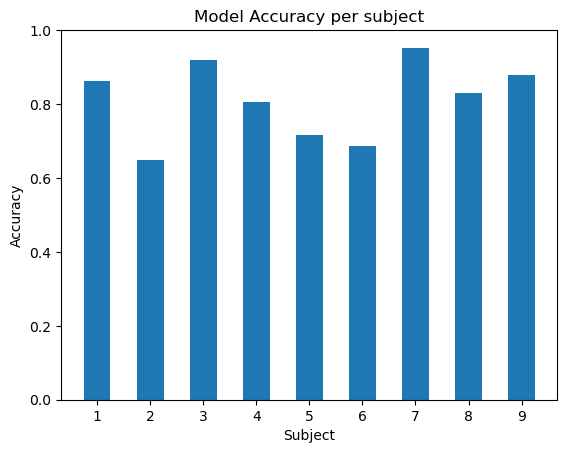

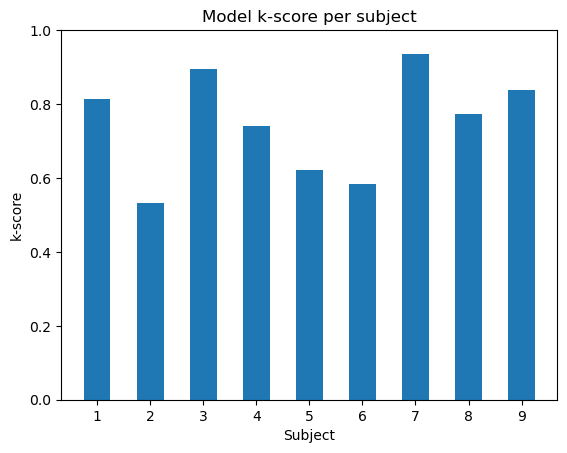

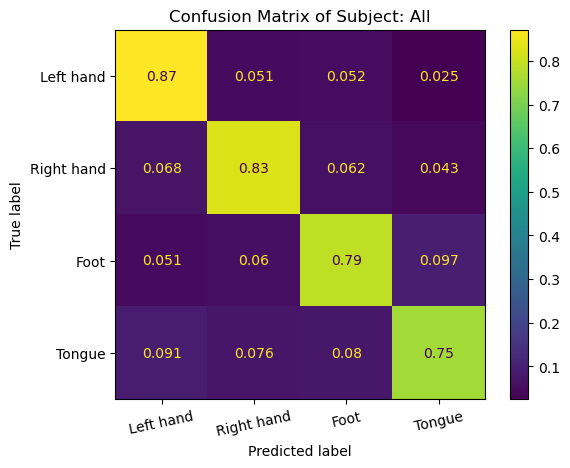

In [31]:
main()